# 무엇을 할 것인가?(서비스)
- 혼잡 & 간섭 문제
무선 혼잡 상황 판별, 예측하여  
→ 혼잡 유발 단말 차단, 채널 간섭 시 AP 채널 변경 조치

    사람이 혼잡 & 간섭을 판단하기 어려운가? 어렵다면 인프라 & 단말 데이터를 가지고 혼잡과 간섭을 판별
    할 로직(AI 모델) 개발 시 효과가 존재할 수도 있을 것 같다.

- 에너지 절감
인프라에 접속 된 단말, 접속 될 단말 예측하여  
→ 인프라 출력 파워 감소

- 음영 개선
특정 위치 감도 저하 판별(음영)  
→ 인프라 출력 조절하여 임시 대응

- 디바이스 위치 및 상태 확인
디바이스 실시간 상태 정보 & 위치 정보  
→ 문제 발생 대응(??) / 문제 발생 예측을 하려면....... PHM 적용?  

-------------------------------------------------------------------------------
### 일단 시도해 볼 예측 모델 생성
- **먼저 핸드오버가 일어나는 상황에 대해 예측 모델을 생성**
- 핸드오버가 예측 가능하다면, 어느 셀에서 어느 셀로 핸드오버가 일어날 지에 대해서 예측 모델 생성  
→ 특정 셀에 대해 핸드오버가 일어날 것을 예측 할 수 있다면 특정 셀 혼잡을 예측할 수 있지 않을 지?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns', None) # 컬럼 다 보이게 하기

In [3]:
knv_origin = pd.read_csv('Data_240307/knv_data_240307.csv', header = None) # 원본 데이터 read

In [4]:
knv_origin.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
0,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8,Column9,Column10,Column11,Column12,Column13,Column14,Column15,Column16,Column17,Column18,Column19,Column20,Column21,Column22,Column23,Column24,Column25,Column26
1,[2024/03/06 13:14:10] 5G,register,33.836,103,100,-82,-15,-67,10,3,16,0/1,-71.5,-21.5,-92.9,-67.8,-16.1,-83.8,-73,-11.3,-84.3,-65.6,-11.1,-76.6,359918920049210,999991829903013
2,[2024/03/06 13:14:10] Wi-Fi,link,11.906,UIWANG_OLT_AGV,80:03:84:b6:f9:a0,44,5220,40,40,206.4,4,5,-110,-66,-67,-70,44,43,40,44,NaN,NaN,NaN,NaN,NaN,NaN
3,[2024/03/06 13:14:11] 5G,register,31.804,103,100,-80,-12,-68,12,2,16,0/1,-68.7,-15.8,-84.4,-63.4,-18.4,-81.7,-73.1,-11.4,-84.4,-70.5,-11.3,-81.8,359918920049210,999991829903013
4,[2024/03/06 13:14:11] Wi-Fi,link,16.71,UIWANG_OLT_AGV,80:03:84:b6:f9:a0,44,5220,40,40,206.4,4,5,-110,-64,-68,-66,46,42,44,46,NaN,NaN,NaN,NaN,NaN,NaN


# 데이터 전처리

In [5]:
# 홀수 행 뽑아내서 5g 데이터 생성
knv_5g = knv_origin.iloc[1::2,:]
# 짝수 행 뽑아내서 wifi 데이터 생성
knv_wifi = knv_origin.iloc[::2,:]
knv_wifi = knv_wifi.drop([0]) # 더미 컬럼 제거

In [6]:
knv_5g.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
1,[2024/03/06 13:14:10] 5G,register,33.836,103,100,-82,-15,-67,10,3,16,0/1,-71.5,-21.5,-92.9,-67.8,-16.1,-83.8,-73,-11.3,-84.3,-65.6,-11.1,-76.6,359918920049210,999991829903013
3,[2024/03/06 13:14:11] 5G,register,31.804,103,100,-80,-12,-68,12,2,16,0/1,-68.7,-15.8,-84.4,-63.4,-18.4,-81.7,-73.1,-11.4,-84.4,-70.5,-11.3,-81.8,359918920049210,999991829903013
5,[2024/03/06 13:14:13] 5G,register,32.682,103,100,-79,-11,-68,12,2,16,0/4,-70,-11.4,-81.3,-62,-16.2,-78.1,-70.3,-11.1,-81.4,-76,-11.8,-87.7,359918920049210,999991829903013


In [7]:
knv_wifi.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
2,[2024/03/06 13:14:10] Wi-Fi,link,11.906,UIWANG_OLT_AGV,80:03:84:b6:f9:a0,44,5220,40,40,206.4,4,5,-110,-66,-67,-70,44,43,40,44,NaN,NaN,NaN,NaN,NaN,NaN
4,[2024/03/06 13:14:11] Wi-Fi,link,16.71,UIWANG_OLT_AGV,80:03:84:b6:f9:a0,44,5220,40,40,206.4,4,5,-110,-64,-68,-66,46,42,44,46,NaN,NaN,NaN,NaN,NaN,NaN
6,[2024/03/06 13:14:13] Wi-Fi,link,14.844,UIWANG_OLT_AGV,80:03:84:b6:f9:a0,44,5220,40,40,206.4,4,5,-110,-63,-66,-65,47,44,45,47,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# 5g 데이터 컬럼명 지정
knv_5g.columns = ['Time', 'Connected', 'Ping_delay', 'PCID', 'TAC', 'RSRP', 'RSRQ', 'RSSI(5G)', 'CQI', 'RI', 'RB', 
                  'MCS Dn/Up', 'Antenna0 Power', 'Antenna0 ECIO', 'Antenna0 RSRP', 
                  'Antenna1 Power', 'Antenna1 ECIO', 'Antenna1 RSRP', 
                  'Antenna2 Power', 'Antenna2 ECIO', 'Antenna2 RSRP', 
                  'Antenna3 Power', 'Antenna3 ECIO', 'Antenna3 RSRP', 'IMEI', 'IMSI']

In [9]:
knv_5g.head(3)

,Time,Connected,Ping_delay,PCID,TAC,RSRP,RSRQ,RSSI(5G),CQI,RI,RB,MCS Dn/Up,Antenna0 Power,Antenna0 ECIO,Antenna0 RSRP,Antenna1 Power,Antenna1 ECIO,Antenna1 RSRP,Antenna2 Power,Antenna2 ECIO,Antenna2 RSRP,Antenna3 Power,Antenna3 ECIO,Antenna3 RSRP,IMEI,IMSI
1,[2024/03/06 13:14:10] 5G,register,33.836,103,100,-82,-15,-67,10,3,16,0/1,-71.5,-21.5,-92.9,-67.8,-16.1,-83.8,-73,-11.3,-84.3,-65.6,-11.1,-76.6,359918920049210,999991829903013
3,[2024/03/06 13:14:11] 5G,register,31.804,103,100,-80,-12,-68,12,2,16,0/1,-68.7,-15.8,-84.4,-63.4,-18.4,-81.7,-73.1,-11.4,-84.4,-70.5,-11.3,-81.8,359918920049210,999991829903013
5,[2024/03/06 13:14:13] 5G,register,32.682,103,100,-79,-11,-68,12,2,16,0/4,-70,-11.4,-81.3,-62,-16.2,-78.1,-70.3,-11.1,-81.4,-76,-11.8,-87.7,359918920049210,999991829903013


In [10]:
# wifi NaN 컬럼 제거 & 데이터 컬럼명 지정
knv_wifi = knv_wifi.drop(knv_wifi.columns[19:26], axis = 1)
knv_wifi.columns = ['Time', 'Connected', 'Ping_delay', 'SSID', 'BSSID', 'Channel', 'Freq', 'Bandwidth',
                    'txpower', 'bitrate', 'MCS_rx', 'MCS_tx', 'Noise_level', 
                    'RSSI', 'AntA_RSSI', 'AntB_RSSI', 'SNR', 'AntA_SNR', 'AntB_SNR',
                    ]

In [11]:
knv_wifi.head(3)

,Time,Connected,Ping_delay,SSID,BSSID,Channel,Freq,Bandwidth,txpower,bitrate,MCS_rx,MCS_tx,Noise_level,RSSI,AntA_RSSI,AntB_RSSI,SNR,AntA_SNR,AntB_SNR
2,[2024/03/06 13:14:10] Wi-Fi,link,11.906,UIWANG_OLT_AGV,80:03:84:b6:f9:a0,44,5220,40,40,206.4,4,5,-110,-66,-67,-70,44,43,40
4,[2024/03/06 13:14:11] Wi-Fi,link,16.71,UIWANG_OLT_AGV,80:03:84:b6:f9:a0,44,5220,40,40,206.4,4,5,-110,-64,-68,-66,46,42,44
6,[2024/03/06 13:14:13] Wi-Fi,link,14.844,UIWANG_OLT_AGV,80:03:84:b6:f9:a0,44,5220,40,40,206.4,4,5,-110,-63,-66,-65,47,44,45


In [12]:
# 5g 데이터 중 데이터프레임 문자열 추출하여 MCS 데이터 분리 https://aait.tistory.com/88
knv_5g['MCS_Dn'] = knv_5g['MCS Dn/Up'].str.split('/', expand = True)[0]
knv_5g['MCS_Up'] = knv_5g['MCS Dn/Up'].str.split('/', expand = True)[1]

C:\Users\6709456\AppData\Local\Temp\ipykernel_22164\2523512146.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knv_5g['MCS_Dn'] = knv_5g['MCS Dn/Up'].str.split('/', expand = True)[0]
C:\Users\6709456\AppData\Local\Temp\ipykernel_22164\2523512146.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knv_5g['MCS_Up'] = knv_5g['MCS Dn/Up'].str.split('/', expand = True)[1]


In [13]:
# 인덱스 초기화 및 inplace
knv_5g.reset_index(drop=True, inplace=True)

In [14]:
knv_5g.head(3)

,Time,Connected,Ping_delay,PCID,TAC,RSRP,RSRQ,RSSI(5G),CQI,RI,RB,MCS Dn/Up,Antenna0 Power,Antenna0 ECIO,Antenna0 RSRP,Antenna1 Power,Antenna1 ECIO,Antenna1 RSRP,Antenna2 Power,Antenna2 ECIO,Antenna2 RSRP,Antenna3 Power,Antenna3 ECIO,Antenna3 RSRP,IMEI,IMSI,MCS_Dn,MCS_Up
0,[2024/03/06 13:14:10] 5G,register,33.836,103,100,-82,-15,-67,10,3,16,0/1,-71.5,-21.5,-92.9,-67.8,-16.1,-83.8,-73,-11.3,-84.3,-65.6,-11.1,-76.6,359918920049210,999991829903013,0,1
1,[2024/03/06 13:14:11] 5G,register,31.804,103,100,-80,-12,-68,12,2,16,0/1,-68.7,-15.8,-84.4,-63.4,-18.4,-81.7,-73.1,-11.4,-84.4,-70.5,-11.3,-81.8,359918920049210,999991829903013,0,1
2,[2024/03/06 13:14:13] 5G,register,32.682,103,100,-79,-11,-68,12,2,16,0/4,-70,-11.4,-81.3,-62,-16.2,-78.1,-70.3,-11.1,-81.4,-76,-11.8,-87.7,359918920049210,999991829903013,0,4


In [15]:
# 'Time' 컬럼 슬라이싱하여 'datetime' 컬럼 생성
knv_5g['datetime'] = pd.to_datetime(knv_5g['Time'].str[1:20])

C:\Users\6709456\AppData\Local\Temp\ipykernel_22164\764653775.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knv_5g['datetime'] = pd.to_datetime(knv_5g['Time'].str[1:20])


In [16]:
# 컬럼 순서 재배열
knv_5g = knv_5g[['Time', 'datetime', 'Connected', 'Ping_delay', 'PCID', 'TAC', 'RSRP', 'RSRQ', 'RSSI(5G)', 
                 'CQI', 'RI', 'RB', 'MCS Dn/Up', 'MCS_Dn', 'MCS_Up',
                 'Antenna0 Power', 'Antenna0 ECIO', 'Antenna0 RSRP', 
                 'Antenna1 Power', 'Antenna1 ECIO', 'Antenna1 RSRP', 
                 'Antenna2 Power', 'Antenna2 ECIO', 'Antenna2 RSRP', 
                 'Antenna3 Power', 'Antenna3 ECIO', 'Antenna3 RSRP',
                 'IMEI', 'IMSI']]

In [17]:
knv_5g.head(3)

,Time,datetime,Connected,Ping_delay,PCID,TAC,RSRP,RSRQ,RSSI(5G),CQI,RI,RB,MCS Dn/Up,MCS_Dn,MCS_Up,Antenna0 Power,Antenna0 ECIO,Antenna0 RSRP,Antenna1 Power,Antenna1 ECIO,Antenna1 RSRP,Antenna2 Power,Antenna2 ECIO,Antenna2 RSRP,Antenna3 Power,Antenna3 ECIO,Antenna3 RSRP,IMEI,IMSI
0,[2024/03/06 13:14:10] 5G,2024-03-06 13:14:10,register,33.836,103,100,-82,-15,-67,10,3,16,0/1,0,1,-71.5,-21.5,-92.9,-67.8,-16.1,-83.8,-73,-11.3,-84.3,-65.6,-11.1,-76.6,359918920049210,999991829903013
1,[2024/03/06 13:14:11] 5G,2024-03-06 13:14:11,register,31.804,103,100,-80,-12,-68,12,2,16,0/1,0,1,-68.7,-15.8,-84.4,-63.4,-18.4,-81.7,-73.1,-11.4,-84.4,-70.5,-11.3,-81.8,359918920049210,999991829903013
2,[2024/03/06 13:14:13] 5G,2024-03-06 13:14:13,register,32.682,103,100,-79,-11,-68,12,2,16,0/4,0,4,-70,-11.4,-81.3,-62,-16.2,-78.1,-70.3,-11.1,-81.4,-76,-11.8,-87.7,359918920049210,999991829903013


In [18]:
# datetime 기준 오름차순 배열 → 이제 필요 없음
# knv_5g = knv_5g.sort_values(by = ['datetime'])

In [19]:
knv_5g

,Time,datetime,Connected,Ping_delay,PCID,TAC,RSRP,RSRQ,RSSI(5G),CQI,RI,RB,MCS Dn/Up,MCS_Dn,MCS_Up,Antenna0 Power,Antenna0 ECIO,Antenna0 RSRP,Antenna1 Power,Antenna1 ECIO,Antenna1 RSRP,Antenna2 Power,Antenna2 ECIO,Antenna2 RSRP,Antenna3 Power,Antenna3 ECIO,Antenna3 RSRP,IMEI,IMSI
0,[2024/03/06 13:14:10] 5G,2024-03-06 13:14:10,register,33.836,103,100,-82,-15,-67,10,3,16,0/1,0,1,-71.5,-21.5,-92.9,-67.8,-16.1,-83.8,-73,-11.3,-84.3,-65.6,-11.1,-76.6,359918920049210,999991829903013
1,[2024/03/06 13:14:11] 5G,2024-03-06 13:14:11,register,31.804,103,100,-80,-12,-68,12,2,16,0/1,0,1,-68.7,-15.8,-84.4,-63.4,-18.4,-81.7,-73.1,-11.4,-84.4,-70.5,-11.3,-81.8,359918920049210,999991829903013
2,[2024/03/06 13:14:13] 5G,2024-03-06 13:14:13,register,32.682,103,100,-79,-11,-68,12,2,16,0/4,0,4,-70,-11.4,-81.3,-62,-16.2,-78.1,-70.3,-11.1,-81.4,-76,-11.8,-87.7,359918920049210,999991829903013
3,[2024/03/06 13:14:14] 5G,2024-03-06 13:14:14,register,32.981,103,100,-81,-14,-66,10,3,16,0/4,0,4,-65.6,-15,-80.6,-62.7,-11.3,-73.9,-72.4,-12,-84.4,-70.5,-11.2,-81.7,359918920049210,999991829903013
4,[2024/03/06 13:14:16] 5G,2024-03-06 13:14:16,register,33.11,103,100,-78,-12,-65,10,3,16,0/4,0,4,-67.6,-13.1,-80.6,-62.9,-14.5,-77.4,-68.8,-11.2,-80,-75.5,-12.4,-87.9,359918920049210,999991829903013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5235,[2024/03/07 10:41:48] 5G,2024-03-07 10:41:48,register,32.433,102,100,-70,-16,-54,11,3,16,0/27,0,27,-61.6,-16.1,-77.7,-54.7,-11.9,-66.6,-59.6,-11.2,-70.8,-57.9,-11.1,-69,359918920049210,999991829903013
5236,[2024/03/07 10:41:49] 5G,2024-03-07 10:41:49,register,33.655,102,100,-65,-11,-54,11,3,16,0/27,0,27,-61.2,-18.4,-79.6,-54.3,-12.2,-66.5,-62.7,-11.3,-74,-59.8,-11.4,-71.1,359918920049210,999991829903013
5237,[2024/03/07 10:41:51] 5G,2024-03-07 10:41:51,register,35.448,102,100,-67,-12,-55,11,3,16,0/27,0,27,-61.5,-16.5,-77.9,-53.5,-11.6,-65,-62.3,-11.3,-73.6,-61.2,-11.3,-72.5,359918920049210,999991829903013
5238,[2024/03/07 10:41:52] 5G,2024-03-07 10:41:52,register,32.929,102,100,-66,-11,-54,11,3,16,0/27,0,27,-60.1,-15.3,-75.3,-54,-12.5,-66.4,-58.6,-11,-69.6,-61.8,-11.2,-73,359918920049210,999991829903013


In [20]:
# 인덱스 초기화 및 inplace
knv_wifi.reset_index(drop=True, inplace=True)

In [21]:
# 'Time' 컬럼 슬라이싱하여 'datetime' 컬럼 생성
knv_wifi['datetime'] = pd.to_datetime(knv_wifi['Time'].str[1:20])

In [22]:
# 컬럼 순서 재배열
knv_wifi = knv_wifi[['Time', 'datetime', 'Connected', 'Ping_delay', 'SSID', 'BSSID', 'Channel', 'Freq', 
                     'Bandwidth', 'txpower', 'bitrate', 'MCS_rx', 'MCS_tx', 
                     'Noise_level', 'RSSI', 'AntA_RSSI', 'AntB_RSSI', 'SNR', 'AntA_SNR', 'AntB_SNR',
                    ]]

In [23]:
knv_wifi

,Time,datetime,Connected,Ping_delay,SSID,BSSID,Channel,Freq,Bandwidth,txpower,bitrate,MCS_rx,MCS_tx,Noise_level,RSSI,AntA_RSSI,AntB_RSSI,SNR,AntA_SNR,AntB_SNR
0,[2024/03/06 13:14:10] Wi-Fi,2024-03-06 13:14:10,link,11.906,UIWANG_OLT_AGV,80:03:84:b6:f9:a0,44,5220,40,40,206.4,4,5,-110,-66,-67,-70,44,43,40
1,[2024/03/06 13:14:11] Wi-Fi,2024-03-06 13:14:11,link,16.71,UIWANG_OLT_AGV,80:03:84:b6:f9:a0,44,5220,40,40,206.4,4,5,-110,-64,-68,-66,46,42,44
2,[2024/03/06 13:14:13] Wi-Fi,2024-03-06 13:14:13,link,14.844,UIWANG_OLT_AGV,80:03:84:b6:f9:a0,44,5220,40,40,206.4,4,5,-110,-63,-66,-65,47,44,45
3,[2024/03/06 13:14:14] Wi-Fi,2024-03-06 13:14:14,link,16.232,UIWANG_OLT_AGV,80:03:84:b6:f9:a0,44,5220,40,40,206.4,4,6,-110,-63,-65,-67,47,45,43
4,[2024/03/06 13:14:16] Wi-Fi,2024-03-06 13:14:16,link,15.614,UIWANG_OLT_AGV,80:03:84:b6:f9:a0,44,5220,40,40,206.4,4,6,-110,-62,-64,-67,48,46,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5235,[2024/03/07 10:41:48] Wi-Fi,2024-03-07 10:41:48,link,7.144,UIWANG_OLT_AGV,80:03:84:bb:2a:20,44,5220,40,40,206.4,4,5,-110,-67,-69,-70,43,41,40
5236,[2024/03/07 10:41:49] Wi-Fi,2024-03-07 10:41:49,link,42.889,UIWANG_OLT_AGV,80:03:84:bb:2a:20,44,5220,40,40,206.4,4,5,-110,-64,-67,-68,46,43,42
5237,[2024/03/07 10:41:51] Wi-Fi,2024-03-07 10:41:51,link,15.216,UIWANG_OLT_AGV,80:03:84:bb:2a:20,44,5220,40,40,206.4,4,5,-110,-65,-67,-68,45,43,42
5238,[2024/03/07 10:41:52] Wi-Fi,2024-03-07 10:41:52,link,16.931,UIWANG_OLT_AGV,80:03:84:bb:2a:20,44,5220,40,40,206.4,4,5,-110,-64,-67,-68,46,43,42


In [24]:
# 5g 데이터 확인, 데이터 형식 정리 필요
knv_5g.describe()

,datetime
count,5240
mean,2024-03-06 20:39:00.882061056
min,2024-03-06 13:14:10
25%,2024-03-06 13:46:26.750000128
50%,2024-03-06 14:20:00
75%,2024-03-07 10:09:26.500000
max,2024-03-07 10:41:54


In [25]:
print(knv_5g.dtypes)

Time                      object
datetime          datetime64[ns]
Connected                 object
Ping_delay                object
PCID                      object
TAC                       object
RSRP                      object
RSRQ                      object
RSSI(5G)                  object
CQI                       object
RI                        object
RB                        object
MCS Dn/Up                 object
MCS_Dn                    object
MCS_Up                    object
Antenna0 Power            object
Antenna0 ECIO             object
Antenna0 RSRP             object
Antenna1 Power            object
Antenna1 ECIO             object
Antenna1 RSRP             object
Antenna2 Power            object
Antenna2 ECIO             object
Antenna2 RSRP             object
Antenna3 Power            object
Antenna3 ECIO             object
Antenna3 RSRP             object
IMEI                      object
IMSI                      object
dtype: object


In [26]:
# CQI, RI float 값
'''knv_5g['Ping_delay'] = knv_5g['Ping_delay'].astype('float')
knv_5g['PCID'] = knv_5g['PCID'].astype('object')
knv_5g['TAC'] = knv_5g['TAC'].astype('object')
knv_5g['RSRP'] = knv_5g['RSRP'].astype('float')
knv_5g['RSRQ'] = knv_5g['RSRQ'].astype('float')
knv_5g['RSSI(5G)'] = knv_5g['RSSI(5G)'].astype('float')
knv_5g['CQI'] = knv_5g['CQI'].astype('float')
knv_5g['RI'] = knv_5g['RI'].astype('float')
knv_5g['RB'] = knv_5g['RB'].astype('float')
knv_5g['MCS Dn/Up'] = knv_5g['MCS Dn/Up'].astype('object')
knv_5g['MCS_Dn'] = knv_5g['MCS_Dn'].astype('object')
knv_5g['MCS_Up'] = knv_5g['MCS_Up'].astype('object')
knv_5g['Antenna0 Power'] = knv_5g['Antenna0 Power'].astype('float')
knv_5g['Antenna0 ECIO'] = knv_5g['Antenna0 ECIO'].astype('float')
knv_5g['Antenna0 RSRP'] = knv_5g['Antenna0 RSRP'].astype('float')
knv_5g['Antenna1 Power'] = knv_5g['Antenna1 Power'].astype('float')
knv_5g['Antenna1 ECIO'] = knv_5g['Antenna1 ECIO'].astype('float')
knv_5g['Antenna1 RSRP'] = knv_5g['Antenna1 RSRP'].astype('float')
knv_5g['Antenna2 Power'] = knv_5g['Antenna2 Power'].astype('float')
knv_5g['Antenna2 ECIO'] = knv_5g['Antenna2 ECIO'].astype('float')
knv_5g['Antenna2 RSRP'] = knv_5g['Antenna2 RSRP'].astype('float')
knv_5g['Antenna3 Power'] = knv_5g['Antenna3 Power'].astype('float')
knv_5g['Antenna3 ECIO'] = knv_5g['Antenna3 ECIO'].astype('float')
knv_5g['Antenna3 RSRP'] = knv_5g['Antenna3 RSRP'].astype('float')
knv_5g['IMEI'] = knv_5g['IMEI'].astype('object')
knv_5g['IMSI'] = knv_5g['IMSI'].astype('object')
'''

"knv_5g['Ping_delay'] = knv_5g['Ping_delay'].astype('float')\nknv_5g['PCID'] = knv_5g['PCID'].astype('object')\nknv_5g['TAC'] = knv_5g['TAC'].astype('object')\nknv_5g['RSRP'] = knv_5g['RSRP'].astype('float')\nknv_5g['RSRQ'] = knv_5g['RSRQ'].astype('float')\nknv_5g['RSSI(5G)'] = knv_5g['RSSI(5G)'].astype('float')\nknv_5g['CQI'] = knv_5g['CQI'].astype('float')\nknv_5g['RI'] = knv_5g['RI'].astype('float')\nknv_5g['RB'] = knv_5g['RB'].astype('float')\nknv_5g['MCS Dn/Up'] = knv_5g['MCS Dn/Up'].astype('object')\nknv_5g['MCS_Dn'] = knv_5g['MCS_Dn'].astype('object')\nknv_5g['MCS_Up'] = knv_5g['MCS_Up'].astype('object')\nknv_5g['Antenna0 Power'] = knv_5g['Antenna0 Power'].astype('float')\nknv_5g['Antenna0 ECIO'] = knv_5g['Antenna0 ECIO'].astype('float')\nknv_5g['Antenna0 RSRP'] = knv_5g['Antenna0 RSRP'].astype('float')\nknv_5g['Antenna1 Power'] = knv_5g['Antenna1 Power'].astype('float')\nknv_5g['Antenna1 ECIO'] = knv_5g['Antenna1 ECIO'].astype('float')\nknv_5g['Antenna1 RSRP'] = knv_5g['Antenna

In [27]:
# CQI, RI object 값
knv_5g['Ping_delay'] = knv_5g['Ping_delay'].astype('float')
knv_5g['PCID'] = knv_5g['PCID'].astype('object')
knv_5g['TAC'] = knv_5g['TAC'].astype('object')
knv_5g['RSRP'] = knv_5g['RSRP'].astype('float')
knv_5g['RSRQ'] = knv_5g['RSRQ'].astype('float')
knv_5g['RSSI(5G)'] = knv_5g['RSSI(5G)'].astype('float')
knv_5g['CQI'] = knv_5g['CQI'].astype('object')
knv_5g['RI'] = knv_5g['RI'].astype('object')
knv_5g['RB'] = knv_5g['RB'].astype('float')
knv_5g['MCS Dn/Up'] = knv_5g['MCS Dn/Up'].astype('object')
knv_5g['MCS_Dn'] = knv_5g['MCS_Dn'].astype('object')
knv_5g['MCS_Up'] = knv_5g['MCS_Up'].astype('object')
knv_5g['Antenna0 Power'] = knv_5g['Antenna0 Power'].astype('float')
knv_5g['Antenna0 ECIO'] = knv_5g['Antenna0 ECIO'].astype('float')
knv_5g['Antenna0 RSRP'] = knv_5g['Antenna0 RSRP'].astype('float')
knv_5g['Antenna1 Power'] = knv_5g['Antenna1 Power'].astype('float')
knv_5g['Antenna1 ECIO'] = knv_5g['Antenna1 ECIO'].astype('float')
knv_5g['Antenna1 RSRP'] = knv_5g['Antenna1 RSRP'].astype('float')
knv_5g['Antenna2 Power'] = knv_5g['Antenna2 Power'].astype('float')
knv_5g['Antenna2 ECIO'] = knv_5g['Antenna2 ECIO'].astype('float')
knv_5g['Antenna2 RSRP'] = knv_5g['Antenna2 RSRP'].astype('float')
knv_5g['Antenna3 Power'] = knv_5g['Antenna3 Power'].astype('float')
knv_5g['Antenna3 ECIO'] = knv_5g['Antenna3 ECIO'].astype('float')
knv_5g['Antenna3 RSRP'] = knv_5g['Antenna3 RSRP'].astype('float')
knv_5g['IMEI'] = knv_5g['IMEI'].astype('object')
knv_5g['IMSI'] = knv_5g['IMSI'].astype('object')

In [28]:
knv_5g.describe()

,datetime,Ping_delay,RSRP,RSRQ,RSSI(5G),RB,Antenna0 Power,Antenna0 ECIO,Antenna0 RSRP,Antenna1 Power,Antenna1 ECIO,Antenna1 RSRP,Antenna2 Power,Antenna2 ECIO,Antenna2 RSRP,Antenna3 Power,Antenna3 ECIO,Antenna3 RSRP
count,5240,5239.000000,5240.000000,5240.000000,5240.000000,5240.000000,5240.000000,5240.000000,5240.000000,5240.000000,5240.000000,5240.000000,5240.000000,5240.000000,5240.000000,5240.000000,5240.000000,5240.000000
mean,2024-03-06 20:39:00.882061056,33.892784,-68.597901,-11.516603,-56.633397,15.987786,-61.324618,-12.701374,-73.902080,-58.539637,-12.715992,-71.122233,-64.503282,-11.143550,-75.646698,-62.050802,-11.144752,-73.237004
min,2024-03-06 13:14:10,5.812000,-90.000000,-20.000000,-75.000000,8.000000,-120.000000,-43.000000,-140.000000,-120.000000,-43.000000,-140.000000,-120.000000,-13.800000,-140.000000,-120.000000,-13.800000,-140.000000
25%,2024-03-06 13:46:26.750000128,30.924500,-74.000000,-12.000000,-61.000000,16.000000,-65.800000,-13.900000,-79.300000,-63.100000,-13.700000,-76.500000,-67.700000,-11.200000,-79.000000,-65.700000,-11.200000,-76.900000
50%,2024-03-06 14:20:00,33.388000,-68.000000,-11.000000,-56.000000,16.000000,-60.950000,-11.800000,-73.900000,-58.200000,-11.900000,-70.900000,-64.000000,-11.100000,-75.100000,-60.900000,-11.100000,-71.900000
75%,2024-03-07 10:09:26.500000,35.373000,-64.000000,-10.000000,-53.000000,16.000000,-57.200000,-10.800000,-68.575000,-54.200000,-10.800000,-65.800000,-59.800000,-10.900000,-70.700000,-56.500000,-10.900000,-67.475000
max,2024-03-07 10:41:54,133.103000,0.000000,0.000000,0.000000,48.000000,-35.800000,-10.200000,-46.100000,-35.100000,-10.200000,-45.400000,-44.900000,-10.800000,-44.000000,-40.700000,-10.800000,-44.000000
std,NaN,11.990051,7.650679,2.097479,6.561247,0.765652,7.357765,2.863984,8.664341,7.607011,2.937037,8.928187,7.394392,0.345992,7.993979,9.177408,0.400223,10.053956


In [29]:
# sns.pairplot(knv_5g, vars = ['Antenna0 RSRP', 'H/O'])

In [30]:
knv_5g

,Time,datetime,Connected,Ping_delay,PCID,TAC,RSRP,RSRQ,RSSI(5G),CQI,RI,RB,MCS Dn/Up,MCS_Dn,MCS_Up,Antenna0 Power,Antenna0 ECIO,Antenna0 RSRP,Antenna1 Power,Antenna1 ECIO,Antenna1 RSRP,Antenna2 Power,Antenna2 ECIO,Antenna2 RSRP,Antenna3 Power,Antenna3 ECIO,Antenna3 RSRP,IMEI,IMSI
0,[2024/03/06 13:14:10] 5G,2024-03-06 13:14:10,register,33.836,103,100,-82.0,-15.0,-67.0,10,3,16.0,0/1,0,1,-71.5,-21.5,-92.9,-67.8,-16.1,-83.8,-73.0,-11.3,-84.3,-65.6,-11.1,-76.6,359918920049210,999991829903013
1,[2024/03/06 13:14:11] 5G,2024-03-06 13:14:11,register,31.804,103,100,-80.0,-12.0,-68.0,12,2,16.0,0/1,0,1,-68.7,-15.8,-84.4,-63.4,-18.4,-81.7,-73.1,-11.4,-84.4,-70.5,-11.3,-81.8,359918920049210,999991829903013
2,[2024/03/06 13:14:13] 5G,2024-03-06 13:14:13,register,32.682,103,100,-79.0,-11.0,-68.0,12,2,16.0,0/4,0,4,-70.0,-11.4,-81.3,-62.0,-16.2,-78.1,-70.3,-11.1,-81.4,-76.0,-11.8,-87.7,359918920049210,999991829903013
3,[2024/03/06 13:14:14] 5G,2024-03-06 13:14:14,register,32.981,103,100,-81.0,-14.0,-66.0,10,3,16.0,0/4,0,4,-65.6,-15.0,-80.6,-62.7,-11.3,-73.9,-72.4,-12.0,-84.4,-70.5,-11.2,-81.7,359918920049210,999991829903013
4,[2024/03/06 13:14:16] 5G,2024-03-06 13:14:16,register,33.110,103,100,-78.0,-12.0,-65.0,10,3,16.0,0/4,0,4,-67.6,-13.1,-80.6,-62.9,-14.5,-77.4,-68.8,-11.2,-80.0,-75.5,-12.4,-87.9,359918920049210,999991829903013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5235,[2024/03/07 10:41:48] 5G,2024-03-07 10:41:48,register,32.433,102,100,-70.0,-16.0,-54.0,11,3,16.0,0/27,0,27,-61.6,-16.1,-77.7,-54.7,-11.9,-66.6,-59.6,-11.2,-70.8,-57.9,-11.1,-69.0,359918920049210,999991829903013
5236,[2024/03/07 10:41:49] 5G,2024-03-07 10:41:49,register,33.655,102,100,-65.0,-11.0,-54.0,11,3,16.0,0/27,0,27,-61.2,-18.4,-79.6,-54.3,-12.2,-66.5,-62.7,-11.3,-74.0,-59.8,-11.4,-71.1,359918920049210,999991829903013
5237,[2024/03/07 10:41:51] 5G,2024-03-07 10:41:51,register,35.448,102,100,-67.0,-12.0,-55.0,11,3,16.0,0/27,0,27,-61.5,-16.5,-77.9,-53.5,-11.6,-65.0,-62.3,-11.3,-73.6,-61.2,-11.3,-72.5,359918920049210,999991829903013
5238,[2024/03/07 10:41:52] 5G,2024-03-07 10:41:52,register,32.929,102,100,-66.0,-11.0,-54.0,11,3,16.0,0/27,0,27,-60.1,-15.3,-75.3,-54.0,-12.5,-66.4,-58.6,-11.0,-69.6,-61.8,-11.2,-73.0,359918920049210,999991829903013


# 시각화

In [31]:
import seaborn as sns

C:\Users\6709456\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\6709456\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


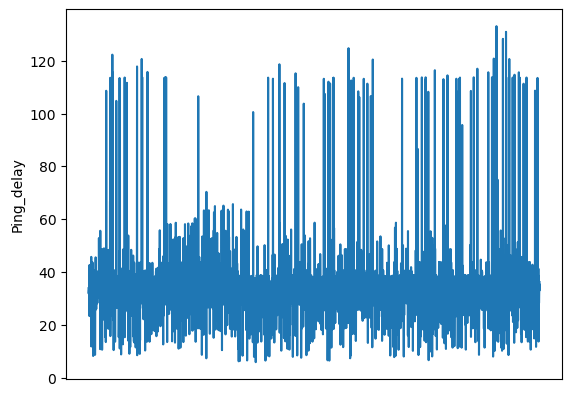

In [32]:
sns.lineplot(x = 'Time', y = 'Ping_delay', data = knv_5g)
plt.gca().axes.xaxis.set_visible(False)
plt.show()

C:\Users\6709456\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\6709456\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


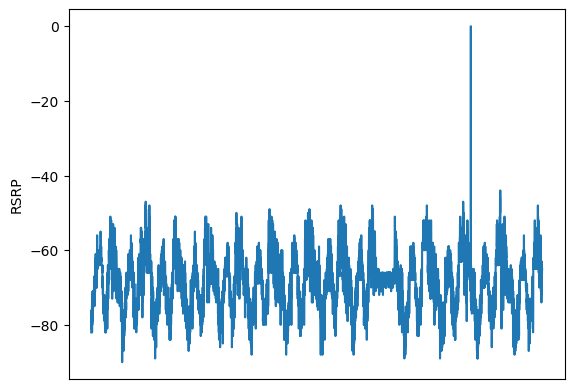

In [33]:
sns.lineplot(x = 'Time', y = 'RSRP', data = knv_5g)
plt.gca().axes.xaxis.set_visible(False)
plt.show()

C:\Users\6709456\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\6709456\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


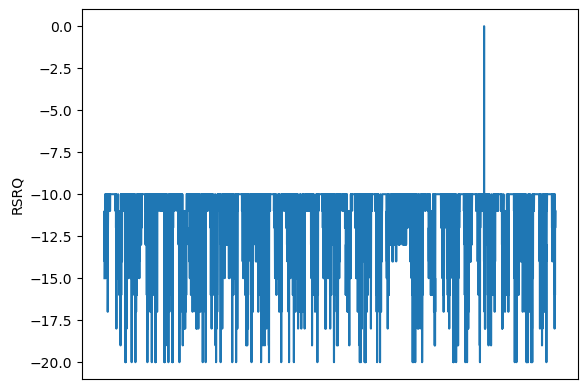

In [34]:
sns.lineplot(x = 'Time', y = 'RSRQ', data = knv_5g)
plt.gca().axes.xaxis.set_visible(False)
plt.show()

In [35]:
# 이상치 제거
knv_5g = knv_5g.drop(knv_5g[knv_5g['RSRP'] == 0].index) # 더미 컬럼 제거

In [36]:
# 이상치 제거 확인
knv_5g.describe()

,datetime,Ping_delay,RSRP,RSRQ,RSSI(5G),RB,Antenna0 Power,Antenna0 ECIO,Antenna0 RSRP,Antenna1 Power,Antenna1 ECIO,Antenna1 RSRP,Antenna2 Power,Antenna2 ECIO,Antenna2 RSRP,Antenna3 Power,Antenna3 ECIO,Antenna3 RSRP
count,5239,5238.000000,5239.000000,5239.000000,5239.000000,5239.000000,5239.000000,5239.000000,5239.000000,5239.000000,5239.000000,5239.000000,5239.000000,5239.000000,5239.000000,5239.000000,5239.000000,5239.000000
mean,2024-03-06 20:38:51.465356032,33.893763,-68.610994,-11.518801,-56.644207,15.987784,-61.325062,-12.700954,-73.902081,-58.540638,-12.716320,-71.123554,-64.502939,-11.143501,-75.646307,-62.049475,-11.144589,-73.235522
min,2024-03-06 13:14:10,5.812000,-90.000000,-20.000000,-75.000000,8.000000,-120.000000,-43.000000,-140.000000,-120.000000,-43.000000,-140.000000,-120.000000,-13.800000,-140.000000,-120.000000,-13.800000,-140.000000
25%,2024-03-06 13:46:26.500000,30.931250,-74.000000,-12.000000,-61.000000,16.000000,-65.800000,-13.900000,-79.300000,-63.100000,-13.700000,-76.500000,-67.700000,-11.200000,-79.000000,-65.700000,-11.200000,-76.900000
50%,2024-03-06 14:19:59,33.388000,-68.000000,-11.000000,-56.000000,16.000000,-61.000000,-11.800000,-73.900000,-58.200000,-11.900000,-70.900000,-64.000000,-11.100000,-75.100000,-60.900000,-11.100000,-71.900000
75%,2024-03-07 10:09:25.500000,35.374000,-64.000000,-10.000000,-53.000000,16.000000,-57.200000,-10.800000,-68.550000,-54.200000,-10.800000,-65.800000,-59.800000,-10.900000,-70.700000,-56.500000,-10.900000,-67.450000
max,2024-03-07 10:41:54,133.103000,-44.000000,-10.000000,-34.000000,48.000000,-35.800000,-10.200000,-46.100000,-35.100000,-10.200000,-45.400000,-44.900000,-10.800000,-44.000000,-40.700000,-10.800000,-44.000000
std,NaN,11.990987,7.592464,2.091634,6.515040,0.765725,7.358397,2.864096,8.665168,7.607392,2.937221,8.928527,7.395056,0.346007,7.994692,9.177782,0.400087,10.054344


C:\Users\6709456\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\6709456\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


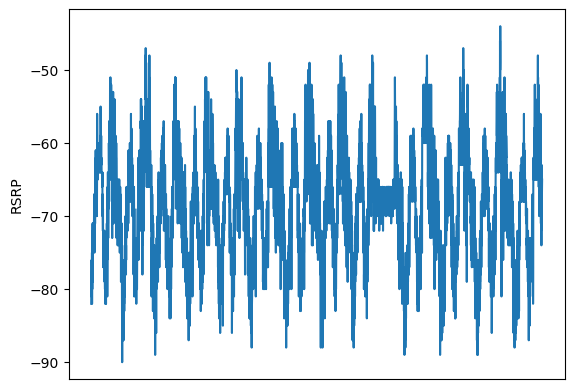

In [37]:
sns.lineplot(x = 'Time', y = 'RSRP', data = knv_5g)
plt.gca().axes.xaxis.set_visible(False)
plt.show()

C:\Users\6709456\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\6709456\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


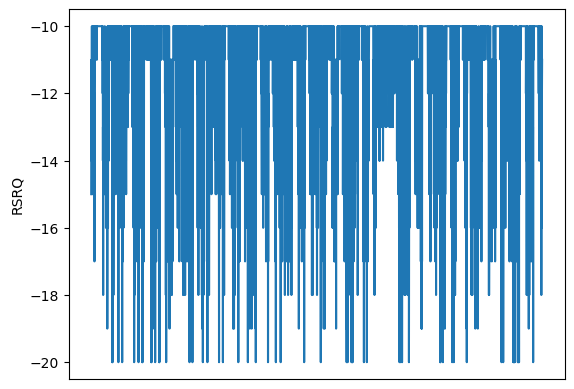

In [38]:
sns.lineplot(x = 'Time', y = 'RSRQ', data = knv_5g)
plt.gca().axes.xaxis.set_visible(False)
plt.show()

# 타겟 값 생성

In [39]:
knv_5g

,Time,datetime,Connected,Ping_delay,PCID,TAC,RSRP,RSRQ,RSSI(5G),CQI,RI,RB,MCS Dn/Up,MCS_Dn,MCS_Up,Antenna0 Power,Antenna0 ECIO,Antenna0 RSRP,Antenna1 Power,Antenna1 ECIO,Antenna1 RSRP,Antenna2 Power,Antenna2 ECIO,Antenna2 RSRP,Antenna3 Power,Antenna3 ECIO,Antenna3 RSRP,IMEI,IMSI
0,[2024/03/06 13:14:10] 5G,2024-03-06 13:14:10,register,33.836,103,100,-82.0,-15.0,-67.0,10,3,16.0,0/1,0,1,-71.5,-21.5,-92.9,-67.8,-16.1,-83.8,-73.0,-11.3,-84.3,-65.6,-11.1,-76.6,359918920049210,999991829903013
1,[2024/03/06 13:14:11] 5G,2024-03-06 13:14:11,register,31.804,103,100,-80.0,-12.0,-68.0,12,2,16.0,0/1,0,1,-68.7,-15.8,-84.4,-63.4,-18.4,-81.7,-73.1,-11.4,-84.4,-70.5,-11.3,-81.8,359918920049210,999991829903013
2,[2024/03/06 13:14:13] 5G,2024-03-06 13:14:13,register,32.682,103,100,-79.0,-11.0,-68.0,12,2,16.0,0/4,0,4,-70.0,-11.4,-81.3,-62.0,-16.2,-78.1,-70.3,-11.1,-81.4,-76.0,-11.8,-87.7,359918920049210,999991829903013
3,[2024/03/06 13:14:14] 5G,2024-03-06 13:14:14,register,32.981,103,100,-81.0,-14.0,-66.0,10,3,16.0,0/4,0,4,-65.6,-15.0,-80.6,-62.7,-11.3,-73.9,-72.4,-12.0,-84.4,-70.5,-11.2,-81.7,359918920049210,999991829903013
4,[2024/03/06 13:14:16] 5G,2024-03-06 13:14:16,register,33.110,103,100,-78.0,-12.0,-65.0,10,3,16.0,0/4,0,4,-67.6,-13.1,-80.6,-62.9,-14.5,-77.4,-68.8,-11.2,-80.0,-75.5,-12.4,-87.9,359918920049210,999991829903013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5235,[2024/03/07 10:41:48] 5G,2024-03-07 10:41:48,register,32.433,102,100,-70.0,-16.0,-54.0,11,3,16.0,0/27,0,27,-61.6,-16.1,-77.7,-54.7,-11.9,-66.6,-59.6,-11.2,-70.8,-57.9,-11.1,-69.0,359918920049210,999991829903013
5236,[2024/03/07 10:41:49] 5G,2024-03-07 10:41:49,register,33.655,102,100,-65.0,-11.0,-54.0,11,3,16.0,0/27,0,27,-61.2,-18.4,-79.6,-54.3,-12.2,-66.5,-62.7,-11.3,-74.0,-59.8,-11.4,-71.1,359918920049210,999991829903013
5237,[2024/03/07 10:41:51] 5G,2024-03-07 10:41:51,register,35.448,102,100,-67.0,-12.0,-55.0,11,3,16.0,0/27,0,27,-61.5,-16.5,-77.9,-53.5,-11.6,-65.0,-62.3,-11.3,-73.6,-61.2,-11.3,-72.5,359918920049210,999991829903013
5238,[2024/03/07 10:41:52] 5G,2024-03-07 10:41:52,register,32.929,102,100,-66.0,-11.0,-54.0,11,3,16.0,0/27,0,27,-60.1,-15.3,-75.3,-54.0,-12.5,-66.4,-58.6,-11.0,-69.6,-61.8,-11.2,-73.0,359918920049210,999991829903013


In [40]:
# 타겟 초기 값 생성 & 타겟 값 부여, 핸드오버 1초 전 데이터를 'H/O' = 'Ready'로 지정
# knv_5g['H/O'] = 'Not Ready'
# for i in range(len(knv_5g) - 1) :
#     if knv_5g.loc[i, 'PCID'] != knv_5g.loc[i+1, 'PCID'] :
#         knv_5g.loc[i, 'H/O'] = 'Ready'

In [41]:
# 이상치 제거 후 인덱스 초기화
knv_5g.reset_index(drop=True, inplace=True)

In [42]:
# 타겟 초기 값 생성 & 타겟 값 부여, 핸드오버 1,2,3초 전 데이터를 'H/O' = 'Ready'로 지정
knv_5g['H/O'] = 'Not Ready'
for i in range(len(knv_5g) - 3) :
    if (knv_5g.loc[i, 'PCID'] != knv_5g.loc[i+1, 'PCID']) or (knv_5g.loc[i, 'PCID'] != knv_5g.loc[i+2, 'PCID']) or (knv_5g.loc[i, 'PCID'] != knv_5g.loc[i+3, 'PCID']) :
        knv_5g.loc[i, 'H/O'] = 'Ready'

In [43]:
# 'Ready' 값 부여 확인
knv_5g[knv_5g['H/O'] == 'Ready']

,Time,datetime,Connected,Ping_delay,PCID,TAC,RSRP,RSRQ,RSSI(5G),CQI,RI,RB,MCS Dn/Up,MCS_Dn,MCS_Up,Antenna0 Power,Antenna0 ECIO,Antenna0 RSRP,Antenna1 Power,Antenna1 ECIO,Antenna1 RSRP,Antenna2 Power,Antenna2 ECIO,Antenna2 RSRP,Antenna3 Power,Antenna3 ECIO,Antenna3 RSRP,IMEI,IMSI,H/O
156,[2024/03/06 13:17:57] 5G,2024-03-06 13:17:57,register,33.642,103,100,-79.0,-11.0,-67.0,10,3,16.0,0/19,0,19,-69.5,-11.4,-80.9,-68.5,-13.6,-82.1,-72.4,-11.1,-83.4,-68.9,-11.2,-80.1,359918920049210,999991829903013,Ready
157,[2024/03/06 13:17:58] 5G,2024-03-06 13:17:58,register,10.519,103,100,-78.0,-12.0,-66.0,10,3,16.0,0/19,0,19,-71.0,-11.4,-82.3,-65.2,-18.8,-83.9,-69.7,-11.0,-80.7,-66.9,-10.9,-77.8,359918920049210,999991829903013,Ready
158,[2024/03/06 13:17:59] 5G,2024-03-06 13:17:59,register,28.058,103,100,-78.0,-10.0,-67.0,11,3,16.0,0/19,0,19,-69.3,-13.8,-83.1,-62.0,-12.0,-74.0,-75.9,-11.0,-86.9,-69.2,-11.4,-80.5,359918920049210,999991829903013,Ready
171,[2024/03/06 13:18:18] 5G,2024-03-06 13:18:18,register,33.169,102,100,-79.0,-13.0,-65.0,10,3,16.0,0/5,0,5,-64.0,-13.2,-77.2,-66.3,-14.3,-80.6,-69.2,-11.5,-80.7,-68.7,-11.2,-79.8,359918920049210,999991829903013,Ready
172,[2024/03/06 13:18:20] 5G,2024-03-06 13:18:20,register,33.526,102,100,-82.0,-16.0,-66.0,10,3,16.0,0/5,0,5,-63.2,-12.5,-75.6,-63.4,-11.3,-74.7,-78.9,-12.3,-91.2,-69.9,-11.2,-81.1,359918920049210,999991829903013,Ready
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5216,[2024/03/07 10:41:20] 5G,2024-03-07 10:41:20,register,15.873,103,100,-61.0,-11.0,-50.0,11,3,16.0,0/22,0,22,-55.9,-16.9,-72.7,-51.6,-14.9,-66.4,-57.9,-11.0,-68.9,-60.2,-11.3,-71.5,359918920049210,999991829903013,Ready
5217,[2024/03/07 10:41:22] 5G,2024-03-07 10:41:22,register,33.349,103,100,-69.0,-14.0,-55.0,11,3,16.0,0/22,0,22,-50.6,-20.3,-70.8,-52.9,-18.0,-70.8,-57.6,-11.0,-68.6,-57.1,-12.3,-69.4,359918920049210,999991829903013,Ready
5223,[2024/03/07 10:41:31] 5G,2024-03-07 10:41:31,register,34.941,101,100,-59.0,-10.0,-48.0,12,1,16.0,0/22,0,22,-57.1,-11.9,-68.9,-56.0,-12.3,-68.2,-60.7,-11.2,-71.8,-61.4,-11.4,-72.8,359918920049210,999991829903013,Ready
5224,[2024/03/07 10:41:32] 5G,2024-03-07 10:41:32,register,36.244,101,100,-71.0,-14.0,-56.0,10,1,16.0,0/22,0,22,-54.1,-12.6,-66.7,-57.1,-12.0,-69.1,-56.9,-11.2,-68.0,-56.1,-11.0,-67.1,359918920049210,999991829903013,Ready


# X/Y split & Train / Test 분리
# 학습 파이프라인 구성

In [44]:
X = knv_5g[['Ping_delay', 'PCID', 'RSRP', 'RSRQ', 'RSSI(5G)', 'CQI', 'RI', 'RB', 'MCS Dn/Up', 'MCS_Dn',
           'MCS_Up',
           'Antenna0 Power', 'Antenna0 ECIO', 'Antenna0 RSRP',
           'Antenna1 Power', 'Antenna1 ECIO', 'Antenna1 RSRP',
           'Antenna2 Power', 'Antenna2 ECIO', 'Antenna2 RSRP',
           'Antenna3 Power', 'Antenna3 ECIO', 'Antenna3 RSRP']]
Y = knv_5g['H/O']

In [45]:
# 모델 생성을 위한 라이브러리 import
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.compose import make_column_transformer # 연속형(숫자) - 연속형 / 범주형(문자) - 범주형

In [46]:
from sklearn.preprocessing import RobustScaler # 중앙값이 0 / IQR 1로 스케일
from sklearn.preprocessing import StandardScaler # 평균과 표준편차 사용
from sklearn.preprocessing import OneHotEncoder # 문자 → 수치 형태의 더미 생성

In [47]:
from sklearn.model_selection import GridSearchCV # 교차검증 + 하이퍼파라미터 튜닝
from sklearn.model_selection import RandomizedSearchCV

In [48]:
# 분류 모델 평가 함수 구성
from sklearn.metrics import classification_report
def evaluation_func(model) : 
    Y_train_pred = model.predict(X_train) # 학습 능력 평가를 위한 예측값 계산
    Y_test_pred = model.predict(X_test) # 일반화 성능 평가를 위한 예측값 계산
    print('학습능력')
    print(classification_report(Y_train, Y_train_pred))
    print('일반화 능력')
    print(classification_report(Y_test, Y_test_pred))

precision : True라고 예측 한 데이터 중 실제로 True 데이터의 비율  
recall : 실제 True인 데이터를 True라고 인식한 데이터의 비율  
F1 : 정밀도와 재현율의 조화평균

In [49]:
# delta 초기 값 생성 & 값 부여
knv_5g['del_RSRP'] = 0
knv_5g['del_RSRQ'] = 0

for i in range(len(knv_5g) -1) :
    knv_5g.loc[i+1, 'del_RSRP'] = knv_5g.loc[i+1, 'RSRP'] - knv_5g.loc[i, 'RSRP']

for i in range(len(knv_5g) -1) :
    knv_5g.loc[i+1, 'del_RSRQ'] = knv_5g.loc[i+1, 'RSRQ'] - knv_5g.loc[i, 'RSRQ']
    
# ddelta 초기 값 생성 & 값 부여
knv_5g['ddel_RSRP'] = 0
knv_5g['ddel_RSRQ'] = 0

for i in range(len(knv_5g) -2) :
    knv_5g.loc[i+2, 'ddel_RSRP'] = knv_5g.loc[i+2, 'RSRP'] - knv_5g.loc[i, 'RSRP']

for i in range(len(knv_5g) -2) :
    knv_5g.loc[i+2, 'ddel_RSRQ'] = knv_5g.loc[i+2, 'RSRQ'] - knv_5g.loc[i, 'RSRQ']
    
# dddelta 초기 값 생성 & 값 부여
knv_5g['dddel_RSRP'] = 0
knv_5g['dddel_RSRQ'] = 0

for i in range(len(knv_5g) -3) :
    knv_5g.loc[i+3, 'dddel_RSRP'] = knv_5g.loc[i+3, 'RSRP'] - knv_5g.loc[i, 'RSRP']

for i in range(len(knv_5g) -3) :
    knv_5g.loc[i+3, 'dddel_RSRQ'] = knv_5g.loc[i+3, 'RSRQ'] - knv_5g.loc[i, 'RSRQ']

In [50]:
knv_5g

,Time,datetime,Connected,Ping_delay,PCID,TAC,RSRP,RSRQ,RSSI(5G),CQI,RI,RB,MCS Dn/Up,MCS_Dn,MCS_Up,Antenna0 Power,Antenna0 ECIO,Antenna0 RSRP,Antenna1 Power,Antenna1 ECIO,Antenna1 RSRP,Antenna2 Power,Antenna2 ECIO,Antenna2 RSRP,Antenna3 Power,Antenna3 ECIO,Antenna3 RSRP,IMEI,IMSI,H/O,del_RSRP,del_RSRQ,ddel_RSRP,ddel_RSRQ,dddel_RSRP,dddel_RSRQ
0,[2024/03/06 13:14:10] 5G,2024-03-06 13:14:10,register,33.836,103,100,-82.0,-15.0,-67.0,10,3,16.0,0/1,0,1,-71.5,-21.5,-92.9,-67.8,-16.1,-83.8,-73.0,-11.3,-84.3,-65.6,-11.1,-76.6,359918920049210,999991829903013,Not Ready,0,0,0,0,0,0
1,[2024/03/06 13:14:11] 5G,2024-03-06 13:14:11,register,31.804,103,100,-80.0,-12.0,-68.0,12,2,16.0,0/1,0,1,-68.7,-15.8,-84.4,-63.4,-18.4,-81.7,-73.1,-11.4,-84.4,-70.5,-11.3,-81.8,359918920049210,999991829903013,Not Ready,2,3,0,0,0,0
2,[2024/03/06 13:14:13] 5G,2024-03-06 13:14:13,register,32.682,103,100,-79.0,-11.0,-68.0,12,2,16.0,0/4,0,4,-70.0,-11.4,-81.3,-62.0,-16.2,-78.1,-70.3,-11.1,-81.4,-76.0,-11.8,-87.7,359918920049210,999991829903013,Not Ready,1,1,3,4,0,0
3,[2024/03/06 13:14:14] 5G,2024-03-06 13:14:14,register,32.981,103,100,-81.0,-14.0,-66.0,10,3,16.0,0/4,0,4,-65.6,-15.0,-80.6,-62.7,-11.3,-73.9,-72.4,-12.0,-84.4,-70.5,-11.2,-81.7,359918920049210,999991829903013,Not Ready,-2,-3,-1,-2,1,1
4,[2024/03/06 13:14:16] 5G,2024-03-06 13:14:16,register,33.110,103,100,-78.0,-12.0,-65.0,10,3,16.0,0/4,0,4,-67.6,-13.1,-80.6,-62.9,-14.5,-77.4,-68.8,-11.2,-80.0,-75.5,-12.4,-87.9,359918920049210,999991829903013,Not Ready,3,2,1,-1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5234,[2024/03/07 10:41:48] 5G,2024-03-07 10:41:48,register,32.433,102,100,-70.0,-16.0,-54.0,11,3,16.0,0/27,0,27,-61.6,-16.1,-77.7,-54.7,-11.9,-66.6,-59.6,-11.2,-70.8,-57.9,-11.1,-69.0,359918920049210,999991829903013,Not Ready,-7,-6,-6,-5,-4,-5
5235,[2024/03/07 10:41:49] 5G,2024-03-07 10:41:49,register,33.655,102,100,-65.0,-11.0,-54.0,11,3,16.0,0/27,0,27,-61.2,-18.4,-79.6,-54.3,-12.2,-66.5,-62.7,-11.3,-74.0,-59.8,-11.4,-71.1,359918920049210,999991829903013,Not Ready,5,5,-2,-1,-1,0
5236,[2024/03/07 10:41:51] 5G,2024-03-07 10:41:51,register,35.448,102,100,-67.0,-12.0,-55.0,11,3,16.0,0/27,0,27,-61.5,-16.5,-77.9,-53.5,-11.6,-65.0,-62.3,-11.3,-73.6,-61.2,-11.3,-72.5,359918920049210,999991829903013,Not Ready,-2,-1,3,4,-4,-2
5237,[2024/03/07 10:41:52] 5G,2024-03-07 10:41:52,register,32.929,102,100,-66.0,-11.0,-54.0,11,3,16.0,0/27,0,27,-60.1,-15.3,-75.3,-54.0,-12.5,-66.4,-58.6,-11.0,-69.6,-61.8,-11.2,-73.0,359918920049210,999991829903013,Not Ready,1,1,-1,0,4,5


In [51]:
X = knv_5g[['Ping_delay', 'PCID', 'RSRP', 'RSRQ', 'RSSI(5G)', 'CQI', 'RI', 'RB', 'MCS Dn/Up', 'MCS_Dn',
           'MCS_Up',
           'Antenna0 Power', 'Antenna0 ECIO', 'Antenna0 RSRP',
           'Antenna1 Power', 'Antenna1 ECIO', 'Antenna1 RSRP',
           'Antenna2 Power', 'Antenna2 ECIO', 'Antenna2 RSRP',
           'Antenna3 Power', 'Antenna3 ECIO', 'Antenna3 RSRP',
           'del_RSRP', 'del_RSRQ', 'ddel_RSRP', 'ddel_RSRQ', 'dddel_RSRP', 'dddel_RSRQ']]
Y = knv_5g['H/O']

In [52]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 8)

In [53]:
numeric_list = X.describe().columns
category_list = X.describe(include = 'object').columns
print(numeric_list)
print(category_list)

Index(['Ping_delay', 'RSRP', 'RSRQ', 'RSSI(5G)', 'RB', 'Antenna0 Power',
       'Antenna0 ECIO', 'Antenna0 RSRP', 'Antenna1 Power', 'Antenna1 ECIO',
       'Antenna1 RSRP', 'Antenna2 Power', 'Antenna2 ECIO', 'Antenna2 RSRP',
       'Antenna3 Power', 'Antenna3 ECIO', 'Antenna3 RSRP', 'del_RSRP',
       'del_RSRQ', 'ddel_RSRP', 'ddel_RSRQ', 'dddel_RSRP', 'dddel_RSRQ'],
      dtype='object')
Index(['PCID', 'CQI', 'RI', 'MCS Dn/Up', 'MCS_Dn', 'MCS_Up'], dtype='object')


In [54]:
# 숫자 파이프 구성(결측값을 다른 값으로 대체 → 스케일링)
numeric_pipe = make_pipeline(SimpleImputer(strategy = 'median'), StandardScaler())
# 문자 파이프 구성(결측값을 최빈값으로 대체 → OneHot 인코딩 수행)
category_pipe = make_pipeline(SimpleImputer(strategy = 'most_frequent'), OneHotEncoder(handle_unknown = 'ignore'))

In [55]:
knv_5g.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5239 entries, 0 to 5238
Data columns (total 36 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Time            5239 non-null   object        
 1   datetime        5239 non-null   datetime64[ns]
 2   Connected       5239 non-null   object        
 3   Ping_delay      5238 non-null   float64       
 4   PCID            5239 non-null   object        
 5   TAC             5239 non-null   object        
 6   RSRP            5239 non-null   float64       
 7   RSRQ            5239 non-null   float64       
 8   RSSI(5G)        5239 non-null   float64       
 9   CQI             5239 non-null   object        
 10  RI              5239 non-null   object        
 11  RB              5239 non-null   float64       
 12  MCS Dn/Up       5239 non-null   object        
 13  MCS_Dn          5239 non-null   object        
 14  MCS_Up          5239 non-null   object        
 15  Ante

In [56]:
numeric_col = list(knv_5g.select_dtypes(exclude = ['object', 'datetime64']))
numeric_piped = numeric_pipe.fit_transform(knv_5g.select_dtypes(exclude = ['object', 'datetime64']))
pd.DataFrame(numeric_piped, columns = numeric_col)

,Ping_delay,RSRP,RSRQ,RSSI(5G),RB,Antenna0 Power,Antenna0 ECIO,Antenna0 RSRP,Antenna1 Power,Antenna1 ECIO,Antenna1 RSRP,Antenna2 Power,Antenna2 ECIO,Antenna2 RSRP,Antenna3 Power,Antenna3 ECIO,Antenna3 RSRP,del_RSRP,del_RSRQ,ddel_RSRP,ddel_RSRQ,dddel_RSRP,dddel_RSRQ
0,-0.004810,-1.763628,-1.664503,-1.589673,0.015955,-1.382898,-3.072483,-2.192656,-1.217269,-1.152110,-1.419904,-1.149129,-0.452345,-1.082533,-0.386898,0.111458,-0.334661,-0.000747,-0.000312,-0.001283,-0.000390,-0.001700,-0.000303
1,-0.174303,-1.500184,-0.230081,-1.743178,0.015955,-1.002344,-1.082136,-1.211623,-0.638829,-1.935238,-1.184681,-1.162653,-0.741384,-1.095043,-0.920847,-0.388481,-0.851900,0.459641,1.227561,-0.001283,-0.000390,-0.001700,-0.000303
2,-0.101067,-1.368462,0.248060,-1.743178,0.015955,-1.179029,0.454272,-0.853835,-0.454780,-1.186159,-0.781440,-0.783985,0.125734,-0.719758,-1.520177,-1.638329,-1.438767,0.229447,0.408979,0.649239,1.632214,-0.001700,-0.000303
3,-0.076127,-1.631906,-1.186362,-1.436167,0.015955,-0.581016,-0.802789,-0.773044,-0.546805,0.482243,-0.310993,-1.067986,-2.475621,-1.095043,-0.920847,-0.138511,-0.841953,-0.461135,-1.228186,-0.218124,-0.816691,0.205395,0.397166
4,-0.065367,-1.236740,-0.230081,-1.282662,0.015955,-0.852840,-0.139340,-0.773044,-0.573098,-0.607326,-0.703033,-0.581128,-0.163305,-0.544625,-1.465693,-3.138146,-1.458661,0.689835,0.818270,0.215558,-0.408540,0.412490,-0.000303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5234,-0.121837,-0.182963,-2.142644,0.405901,0.015955,-0.037367,-1.186891,-0.438339,0.504904,0.277949,0.506689,0.663066,-0.163305,0.606248,0.452165,0.111458,0.421303,-1.612106,-2.456060,-1.302328,-2.041144,-0.830079,-1.987651
5235,-0.019908,0.475648,0.248060,0.405901,0.015955,0.016997,-1.990013,-0.657629,0.557490,0.175802,0.517890,0.243827,-0.452345,0.205945,0.245123,-0.638451,0.212418,1.150224,2.046144,-0.434965,-0.408540,-0.208795,-0.000303
5236,0.129650,0.212204,-0.230081,0.252395,0.015955,-0.023776,-1.326565,-0.461422,0.662661,0.380096,0.685907,0.297922,-0.452345,0.255983,0.092567,-0.388481,0.073162,-0.461135,-0.409604,0.649239,1.632214,-0.830079,-0.795243
5237,-0.080465,0.343926,0.248060,0.405901,0.015955,0.166501,-0.907544,-0.161342,0.596929,0.073655,0.529091,0.798304,0.414774,0.756362,0.027185,-0.138511,0.023427,0.229447,0.408979,-0.218124,-0.000390,0.826679,1.987044


In [57]:
# 연속형 데이터 → 연속형 파이프, 범주형 데이터 → 범주형 파이프
prepro_pipe = make_column_transformer((numeric_pipe, numeric_list), (category_pipe, category_list))
model_pipe = make_pipeline(prepro_pipe, RandomForestClassifier())

In [58]:
prepro_pipe.fit(X_train)
X_train_trans = prepro_pipe.transform(X_train)
print(X_train_trans.shape)

prepro_pipe.fit(X_test)
X_test_trans = prepro_pipe.transform(X_test)
print(X_test_trans.shape)

(3929, 152)
(1310, 119)


In [59]:
hyper_list = {'randomforestclassifier__max_depth' : range(1,10),
              'randomforestclassifier__min_samples_leaf' : range(1,12)}

grid_model = GridSearchCV(model_pipe, param_grid = {}, cv = 5, scoring = 'f1', n_jobs = -1)
grid_model.fit(X_train, Y_train)

C:\Users\6709456\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Ping_delay', 'RSRP', 'RSRQ', 'RSSI(5G)', 'RB', 'Antenna0 Power',
       'Antenna0 ECIO', 'Antenna0 RSRP', 'Antenna1 Power', 'Antenna1 ECIO',
       'Antenn...
       'del_RSRQ', 'ddel_RSRP', 'ddel_RSRQ', 'dddel_RSRP', 'dddel_RSRQ'],
      dtype='object')),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['PCID', 'CQI', 'RI', 'MCS Dn/Up', 'MCS_Dn', 'MCS_Up'], dtype='object'))])),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             n_jobs=-1, param_grid={}, scoring='f1')

In [60]:
# 최적의 모델을 선정
best_model = grid_model.best_estimator_

In [61]:
evaluation_func(best_model)

학습능력
              precision    recall  f1-score   support

   Not Ready       1.00      1.00      1.00      3578
       Ready       1.00      1.00      1.00       351

    accuracy                           1.00      3929
   macro avg       1.00      1.00      1.00      3929
weighted avg       1.00      1.00      1.00      3929

일반화 능력
              precision    recall  f1-score   support

   Not Ready       0.92      1.00      0.96      1200
       Ready       0.67      0.04      0.07       110

    accuracy                           0.92      1310
   macro avg       0.79      0.52      0.51      1310
weighted avg       0.90      0.92      0.88      1310



precision : True라고 예측 한 데이터 중 실제로 True 데이터의 비율  
recall : 실제 True인 데이터를 True라고 인식한 데이터의 비율  
F1 : 정밀도와 재현율의 조화평균

## 모델 중간 평가
- 디바이스 데이터셋만 사용했을 시 성능이 만족스럽지 않았다.
- 데이터셋에 변수를 추가(delta 값)하여 학습을 시켰으나 또한 성능이 만족스럽지 않았다.
- 강력한 성능을 가진 randomforest 모델을 적용하여 모델을 생성하였는데 위와 같이 심한 과적합 현상이 발생
## 개선하기 위해 무얼 할 것인가?
- H/O 예측에 영향을 준 변수 추출하여 확인하여 내 예상(RSRQ가 주요 영향 변수일 것이다.)과 대조해보기
- pairplot 그려서 특성 검토하기
- 소수 데이터 생성하여 다시 모델 생성 & 테스트

### 불균형한 데이터 비율 맞추기(이진 분류에 적합)

In [62]:
# imbalanced data sampling
# !pip install imblearn

In [63]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

In [64]:
model_pipe2 = make_pipeline(prepro_pipe, SMOTE(), RandomForestClassifier())

In [65]:
'''from sklearn.compose import ColumnTransformer

prepro_columns = prepro_pipe.transformers_[0][1].get_feature_names_out()

print("Input features:", prepro_columns)
'''

'from sklearn.compose import ColumnTransformer\n\nprepro_columns = prepro_pipe.transformers_[0][1].get_feature_names_out()\n\nprint("Input features:", prepro_columns)\n'

In [66]:
hyper_list = {'randomforestclassifier__n_estimators' : range(10,15),
              'randomforestclassifier__min_samples_split' : range(2,6),
              'randomforestclassifier__min_samples_leaf' : range(1,6)}

grid_model = GridSearchCV(model_pipe2, param_grid = hyper_list, cv = 5, scoring = 'f1', n_jobs = -1)

In [67]:
grid_model.fit(X_train, Y_train)

C:\Users\6709456\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Ping_delay', 'RSRP', 'RSRQ', 'RSSI(5G)', 'RB', 'Antenna0 Power',
       'Antenna0 ECIO', 'Antenna0 RSRP', 'Antenna1 Power', 'Antenna1 ECIO',
       'Antenn...
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['PCID', 'CQI', 'RI', 'MCS Dn/Up', 'MCS_Dn', 'MCS_Up'], dtype='object'))])),
                                       ('smote', SMOTE()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__min_samples_leaf': range(1, 6),
                         'randomforestclassifier__min_samples_split': range(2, 6),
                         'randomforestclassifier__n_estimators': range(10, 15)},
             scoring='f1')

In [68]:
best_model = grid_model.best_estimator_

In [69]:
evaluation_func(best_model)

학습능력
              precision    recall  f1-score   support

   Not Ready       1.00      1.00      1.00      3578
       Ready       1.00      0.99      0.99       351

    accuracy                           1.00      3929
   macro avg       1.00      0.99      1.00      3929
weighted avg       1.00      1.00      1.00      3929

일반화 능력
              precision    recall  f1-score   support

   Not Ready       0.93      0.97      0.95      1200
       Ready       0.42      0.26      0.32       110

    accuracy                           0.91      1310
   macro avg       0.68      0.62      0.64      1310
weighted avg       0.89      0.91      0.90      1310



In [70]:
print('최적 하이퍼 파라미터: ', grid_model.best_params_)
print('최고 예측 정확도: {:.3f}'.format(grid_model.best_score_))

최적 하이퍼 파라미터:  {'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 10}
최고 예측 정확도: nan


In [71]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [72]:
#make_pipeline(prepro_pipe, SMOTE(), SelectKBest(f_classif, k = 5), RandomForestClassifier())

In [73]:
model_pipe3 = make_pipeline(prepro_pipe, SMOTE(), SelectKBest(f_classif, k = 5), RandomForestClassifier())

In [74]:
dists = {
    'randomforestclassifier__max_depth' : [3, 5, 10],
    'randomforestclassifier__min_samples_split' : [10, 12, 14, 16, 18, 20],
    'randomforestclassifier__min_samples_leaf' : [2, 5, 8]
}

In [75]:
grid_model = RandomizedSearchCV(model_pipe3, param_distributions = dists, 
                          cv = 6, n_iter = 30, scoring = 'f1', n_jobs = -1)
grid_model.fit(X_train, Y_train)

C:\Users\6709456\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


RandomizedSearchCV(cv=6,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               Index(['Ping_delay', 'RSRP', 'RSRQ', 'RSSI(5G)', 'RB', 'Antenna0 Power',
       'Antenna0 ECIO', 'Antenna0 RSRP', 'Antenna1 Power', 'Antenna1 ECIO',
       '...
                                                                               Index(['PCID', 'CQI', 'RI', 'MCS Dn/Up', 'MCS_Dn', 'MCS_Up'], dtype='object'))])),
                                             ('smote', SMOTE()),
                                             ('selectkbest', SelectKBest(k=5)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier())]),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_depth': [3,
                                                                              5,
                                                                              10],
                                        'randomforestclassifier__min_samples_leaf': [2,
                                                                                     5,
                                                                                     8],
                                        'randomforestclassifier__min_samples_split': [10,
                                                                                      12,
                                                                                      14,
                                                                                      16,
                                                                                      18,
                                                                                      20]},
                   scoring='f1')

In [76]:
print(grid_model.best_params_)

{'randomforestclassifier__min_samples_split': 18, 'randomforestclassifier__min_samples_leaf': 8, 'randomforestclassifier__max_depth': 10}


In [77]:
best_model = grid_model.best_estimator_

In [78]:
evaluation_func(best_model)

학습능력
              precision    recall  f1-score   support

   Not Ready       0.96      0.82      0.89      3578
       Ready       0.26      0.65      0.38       351

    accuracy                           0.81      3929
   macro avg       0.61      0.74      0.63      3929
weighted avg       0.90      0.81      0.84      3929

일반화 능력
              precision    recall  f1-score   support

   Not Ready       0.95      0.81      0.88      1200
       Ready       0.20      0.51      0.29       110

    accuracy                           0.79      1310
   macro avg       0.57      0.66      0.58      1310
weighted avg       0.88      0.79      0.83      1310



In [79]:
print('선택된 변수 :', model_pipe3[0].get_feature_names+out())

AttributeError: 'ColumnTransformer' object has no attribute 'get_feature_names'

In [ ]:
# 변수 선택법에 의해 결정된 6가지 특성 확인
best_model['selectkbest'].get_support(indices = True)

In [ ]:
select_num = best_model['selectkbest'].get_support(indices = True)
select_num

In [ ]:
select_col_dict = dict(zip(range(0, len(select_col_list)), select_col_list))
list(map(select_col_dict.get, select_num))

In [ ]:
select_col_dict

In [ ]:
best_model['selectkbest'].get_support(indices = True)

In [ ]:
select_col = list(map(select_col_dict.get, select_num))

In [ ]:
best_model['randomforestclassifier'].feature_importances_

In [ ]:
fi = best_model['randomforestclassifier'].feature_importances_
dict(zip(select_col, fi))

In [ ]:
df_fi = pd.DataFrame(data = fi, columns = ['importance'])
df_fi['feature'] = select_col
display(df_fi)

In [ ]:
import plotly.express as px

In [ ]:
px.bar(df_fi, x = 'feature', y = 'importance')